In [1]:
import talib
from data_sources import get_prices_in_range, get_volumes_in_range
from strategies import  Horizon
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from signals import Signal
from strategies import SignalSignatureStrategy
import operator
from orders import OrderType

# Initial settings
transaction_currency = "ETH"
counter_currency = "BTC"
end_time = 1526637600
start_time = end_time - 60 * 60 * 24 * 60
horizon = Horizon.short
resample_period = 60
start_cash = 1
start_crypto = 0
source = 0
strength = 3
history_size = 100
AVERAGING_PERIOD = 50*60

# Load price and volume data and calculate average prices and volumes
prices_df = get_prices_in_range(start_time, end_time, transaction_currency, counter_currency, source)
prices_df.price /= 1E8

volumes_df = get_volumes_in_range(start_time, end_time, transaction_currency, counter_currency, source)
volumes_df.volume /= 1E5 # scaling for visualization

sma_price = talib.SMA(np.array(prices_df.price, dtype=float), timeperiod=AVERAGING_PERIOD)
sma_volume = talib.SMA(np.array(volumes_df.volume, dtype=float), timeperiod=AVERAGING_PERIOD)

prices_df['average_price'] = pd.Series(sma_price, index=prices_df.index)
volumes_df['average_volume'] = pd.Series(sma_volume, index=volumes_df.index)
price_volume_df = prices_df.join(volumes_df)

# Convert indexes to datetime
prices_df.index = pd.to_datetime(prices_df.index, unit='s')
volumes_df.index = pd.to_datetime(volumes_df.index, unit='s')
price_volume_df.index = pd.to_datetime(price_volume_df.index, unit='s')


In [2]:
def build_signals(percent_change_price, percent_change_volume):
    # build signals
    all_buy_signals = []
    first_cross_buy_signals = []
    valid_in_previous_step = False
    for row in price_volume_df.itertuples():
        timestamp = row.Index.timestamp()
        price = row.price
        volume = row.volume
        avg_price = row.average_price
        avg_volume = row.average_volume

        # check whether to generate a buy signal:
        if price > (1 + percent_change_price)*avg_price and volume > (1 + percent_change_volume)*avg_volume:
            signal = Signal("RSI", 1, Horizon.any, 3, 3, price, 0, timestamp, 0, transaction_currency, counter_currency)
            all_buy_signals.append(signal)
            if not valid_in_previous_step:
                valid_in_previous_step = True
                first_cross_buy_signals.append(signal)
                # print(timestamp, price, avg_price, volume, avg_volume)
        else:
            valid_in_previous_step = False
    return all_buy_signals, first_cross_buy_signals


In [3]:
def build_strategy(percent_change_price, percent_change_volume, buy_only_on_first_cross=True):
    all_buy_signals, first_cross_buy_signals = build_signals(percent_change_price, percent_change_volume)
    
    strategy = SignalSignatureStrategy(["rsi_buy_2", "rsi_sell_2", "rsi_buy_3", "rsi_sell_3"],
                                       start_time, end_time, horizon,
                                       counter_currency, transaction_currency, source)
    rsi_sell_signals = strategy.get_sell_signals()
    
    if buy_only_on_first_cross:
        buy_signals = first_cross_buy_signals
    else:
        buy_signals = all_buy_signals

    buy_signals.extend(rsi_sell_signals)
    sorted_signals = sorted(buy_signals, key=operator.attrgetter('timestamp'))
    
    # burn in hell hacky, but it works :)
    strategy.signals = sorted_signals
    return strategy, all_buy_signals, first_cross_buy_signals


In [4]:
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(0,0,buy_only_on_first_cross=True)
orders, _ = strategy.get_orders(start_cash, start_crypto)

# Backtest the strategy
print(strategy.evaluate(start_cash, start_crypto, start_time, end_time))


Strategy: a simple signal set-based strategy
  description: trading according to signal set ['rsi_buy_2', 'rsi_sell_2', 'rsi_buy_3', 'rsi_sell_3']
Strategy settings:
  horizon = short
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-03-25 18:37:19  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     16.307128 ETH 	 (1 ETH = 0.06116957 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-03-25 18:37:19 rsi_value=0
2018-04-09 10:00:00  	 OrderType.SELL   	 cash_balance ->          0.97 BTC 	 currency_balance ->    -16.307128 ETH 	 (1 ETH = 0.05957500 BTC )
   signal: rsi_sell_2 strength=2 trend=-1 horizon=0 timestamp=2018-04-09 10:00:00 rsi_value=79.8665786455173
2018-04-11 19:23:52  	 OrderType.BUY    	 cash_balance ->         -0.97 BTC 	 currency_balance ->     15.872646 ETH 	 (1 ETH = 0.06090010 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any times

In [5]:
def plot_results(include_all_buy, include_first_cross, include_orders):
    

    ax = price_volume_df.plot(lw=1, title="ETH to BTC")
    volumes_df.plot(lw=2)

    if include_all_buy:
        for signal in all_buy_signals:
            timestamp = pd.to_datetime(signal.timestamp, unit="s")
            price = signal.price
            if signal.trend == 1:
                #ax.axvline(timestamp, color="lightgreen", lw=1)
                circle = plt.Circle((timestamp, price), 0.1, color="lightgreen")
                ax.add_artist(circle)

    if include_first_cross:
        for signal in first_cross_buy_signals:
            timestamp = pd.to_datetime(signal.timestamp, unit="s")
            price = signal.price
            ax.axvline(timestamp, color="pink", lw=1)
            #circle = plt.Circle((timestamp, price), 0.05, color="lightgreen")
            #ax.add_artist(circle)

    if include_orders:
        for order in orders:
            if order.order_type == OrderType.BUY:
                color = "g"
            else:
                color = "r"
            timestamp = pd.to_datetime(order.timestamp, unit="s")
            #timestamp = order.timestamp
            #price = order.unit_price
            ax.axvline(timestamp, color=color, lw=2)
            #circle = plt.Circle((timestamp, price), 0.05, color=color)
            #ax.add_artist(circle)

    ax.set_yticklabels([])
    plt.show()


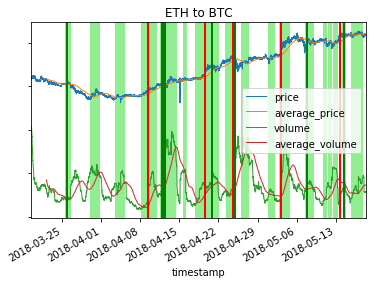

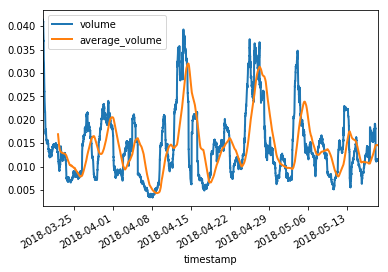

In [6]:
plot_results(include_all_buy=True, include_first_cross=False, include_orders=True)


Strategy: a simple signal set-based strategy
  description: trading according to signal set ['rsi_buy_2', 'rsi_sell_2', 'rsi_buy_3', 'rsi_sell_3']
Strategy settings:
  horizon = short
--

* Order execution log *

Start balance: cash = 1 BTC, crypto = 0 
Start time: 2018-03-19 10:00:00
--
--
2018-03-30 06:21:31  	 OrderType.BUY    	 cash_balance ->         -1.00 BTC 	 currency_balance ->     17.539766 ETH 	 (1 ETH = 0.05687077 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any timestamp=2018-03-30 06:21:31 rsi_value=0
2018-04-09 10:00:00  	 OrderType.SELL   	 cash_balance ->          1.04 BTC 	 currency_balance ->    -17.539766 ETH 	 (1 ETH = 0.05957500 BTC )
   signal: rsi_sell_2 strength=2 trend=-1 horizon=0 timestamp=2018-04-09 10:00:00 rsi_value=79.8665786455173
2018-04-09 18:59:05  	 OrderType.BUY    	 cash_balance ->         -1.04 BTC 	 currency_balance ->     17.739592 ETH 	 (1 ETH = 0.05860977 BTC )
   signal: rsi_buy_3 strength=3 trend=1 horizon=Horizon.any times

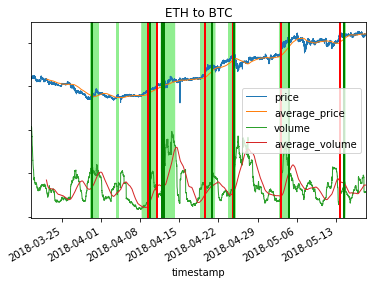

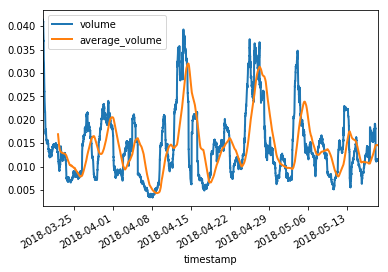

In [7]:
# Let's try another threshold
strategy, all_buy_signals, first_cross_buy_signals = build_strategy(0.02,0.02)
orders, _ = strategy.get_orders(start_cash, start_crypto)

# Backtest the strategy
print(strategy.evaluate(start_cash, start_crypto, start_time, end_time))

# Plot trades
plot_results(True, False, True)

In [8]:
# Try out different thresholds for volume and price change

volume_change_percents = []
price_change_percents = []
profits = []

for percent_change_volume in np.arange(0, 0.05, 0.005):
    for percent_change_price in np.arange(0, 0.05, 0.005):
        strategy, all_buy_signals, first_cross_buy_signals = build_strategy(percent_change_volume,percent_change_price,buy_only_on_first_cross=True)
        orders, _ = strategy.get_orders(start_cash, start_crypto)
        evaluation = strategy.evaluate(start_cash, start_crypto, start_time, end_time, verbose=False)
        volume_change_percents.append(percent_change_volume)
        price_change_percents.append(percent_change_price)
        profits.append(evaluation.get_profit_percent())

        

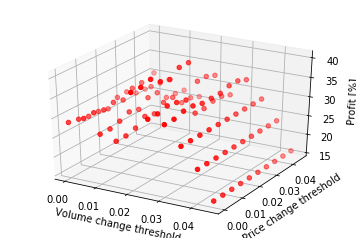

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = volume_change_percents
y = price_change_percents
z = profits


ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Volume change threshold')
ax.set_ylabel('Price change threshold')
ax.set_zlabel('Profit [%]')

plt.show()

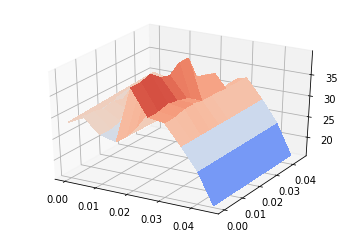

In [10]:
# Interpolated mesh

#%matplotlib notebook
#plt.interactive(True)

fig3d = plt.figure(1)

ax = fig3d.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x, y)
from scipy.interpolate import griddata
from matplotlib import cm
Z = griddata((x, y), z, (X, Y), method='cubic')

surface_plot = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

In [11]:
profit_df = pd.DataFrame.from_items(zip(["Volume change percent", "Price change percent", "Profit percent"], [volume_change_percents, price_change_percents, profits]))

In [12]:
profit_df

,Volume change percent,Price change percent,Profit percent
0,0.000,0.000,28.725808
1,0.000,0.005,28.221301
2,0.000,0.010,27.632039
3,0.000,0.015,27.569058
4,0.000,0.020,26.918348
5,0.000,0.025,28.639340
6,0.000,0.030,28.829609
7,0.000,0.035,27.251887
8,0.000,0.040,26.995254
9,0.000,0.045,30.103347


In [15]:
writer = pd.ExcelWriter("vbi_performance.xlsx")
profit_df.to_excel(writer,"Results")
writer.save()

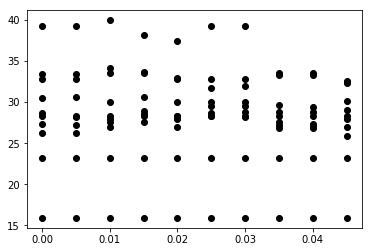

In [17]:
plt.plot(profit_df["Price change percent"], profit_df["Profit percent"], 'o', color='black');